In [1]:
#Librerias
import numpy as np
import pandas as pd
from cesium import featurize
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import classification_report

## Generacion de Datos Sinteticos


              series_id  length  amplitude  frequency     phase  target
0  class0_series_773956     309   2.621401   0.016098  3.364236       0
1  class1_series_514629     396   2.775817   0.015265  4.239495       1
2  class2_series_945693     362   2.804212   0.019577  3.025929       2
3  class3_series_597856     334   1.443205   0.020875  4.910095       3
4  class0_series_329074     331   0.987094   0.025003  4.254822       0


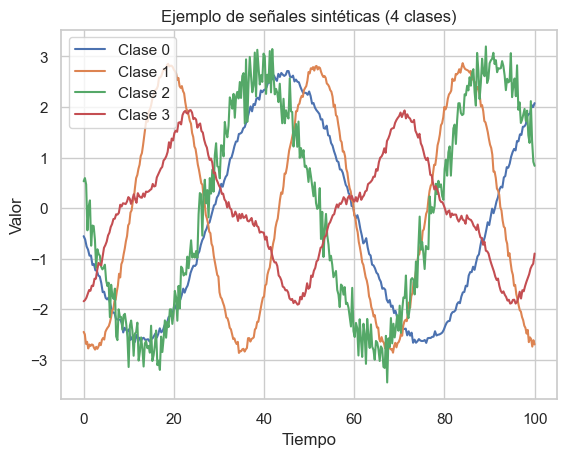

In [2]:
import numpy as np
import pandas as pd

def generate_sine_dataset_multiclass(
    n_series_per_class=50,
    t_min=0.0,
    t_max=100.0,
    min_length=300,
    max_length=400,
    freq_range=(1/100, 1/35),  # rango seguro (~0.01–0.028 Hz)
    amp_range=(0.5, 3.0),
    noise_std_base=0.05,
    jitter_scale=0.01,
    seed=42
):
    rng = np.random.default_rng(seed)
    rows, meta_rows = [], []

    def generate_single_series(class_id, base_freq_mult=1, add_noise=0.05, add_harmonic=False):
        length = int(rng.integers(min_length, max_length + 1))
        t = np.linspace(t_min, t_max, length)
        t += rng.normal(0, jitter_scale * (t_max - t_min) / max(1, length), size=length)
        t = np.clip(t, t_min, t_max)
        t = np.sort(t)

        freq = float(rng.uniform(freq_range[0], freq_range[1]))
        phase = float(rng.uniform(0, 2 * np.pi))
        amp = float(rng.uniform(amp_range[0], amp_range[1]))

        # Señal base
        values = amp * np.sin(2 * np.pi * freq * base_freq_mult * t + phase)

        # Agregar armónico si corresponde
        if add_harmonic:
            values += 0.3 * amp * np.sin(6 * np.pi * freq * t + phase)

        # Agregar ruido
        noise = rng.normal(0, add_noise, size=length)
        values += noise

        sid = f"class{class_id}_series_{rng.integers(1e6)}"
        for ti, vi in zip(t, values):
            rows.append({
                "series_id": sid,
                "t": float(ti),
                "value": float(vi)
            })

        meta_rows.append({
            "series_id": sid,
            "length": length,
            "amplitude": amp,
            "frequency": freq,
            "phase": phase,
            "target": class_id
        })

    # Generar las 4 clases
    for _ in range(n_series_per_class):
        generate_single_series(class_id=0, base_freq_mult=1, add_noise=noise_std_base)        # Clase A: seno puro
        generate_single_series(class_id=1, base_freq_mult=2, add_noise=noise_std_base)        # Clase B: doble frecuencia
        generate_single_series(class_id=2, base_freq_mult=1, add_noise=0.3)                   # Clase C: ruido fuerte
        generate_single_series(class_id=3, base_freq_mult=1, add_noise=noise_std_base, add_harmonic=True)  # Clase D: armónico

    df_long = pd.DataFrame(rows, columns=["series_id", "t", "value"])
    df_meta = pd.DataFrame(meta_rows, columns=["series_id", "length", "amplitude", "frequency", "phase", "target"])

    return df_long, df_meta


# Ejemplo de uso
df_long, df_meta = generate_sine_dataset_multiclass(n_series_per_class=30)
print(df_meta.head())

# Visualizar algunas series
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
for i, c in enumerate(df_meta['target'].unique()):
    sid = df_meta[df_meta['target'] == c].iloc[0]['series_id']
    subset = df_long[df_long['series_id'] == sid]
    plt.plot(subset['t'], subset['value'], label=f"Clase {c}")
plt.legend()
plt.title("Ejemplo de señales sintéticas (4 clases)")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.show()


In [3]:
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]

def extract_features_byCesium(df_all_series,
                              features_to_use=features_to_use,
                              min_points_per_serie=5):

    full_object_list = sorted(df_all_series['series_id'].unique())

    grouped = df_all_series.groupby('series_id')

    time_list = []
    value_list = []
    object_list = []

    for obj_id,g in grouped:
        g = g.sort_values('t')
        if len(g) < min_points_per_serie:
            print(f"Skipping series_id {obj_id} with only {len(g)} points")
            continue

        time_list.append(g['t'].values)
        value_list.append(g['value'].values)
        object_list.append(obj_id)

    if len(object_list) == 0:
        raise ValueError("No series with enough points found.")
    
    ds = featurize.featurize_time_series(times=time_list,
                                         values=value_list,
                                         features_to_use=features_to_use,
                                         scheduler='threads'
                                         )

    if len(ds) == len(object_list):
        ds.index = object_list

    #ds = ds.reset_index().rename(columns={'index': 'object_id'})
            
    
    return ds


In [4]:
#Generamos un df con las features
df_features = extract_features_byCesium(df_long,
                                        features_to_use=features_to_use,
                                        min_points_per_serie=5)

## Gaussian Mixture Model

✅ Datos alineados: 120 series, 4 clases.
✅ Modelos GMM entrenados para clases: [0 1 2 3]

🔹 Accuracy GMM: 1.000

🔹 Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        30
           3       1.00      1.00      1.00        30

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



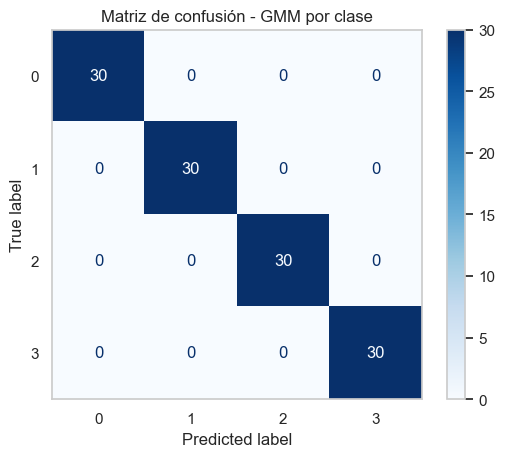

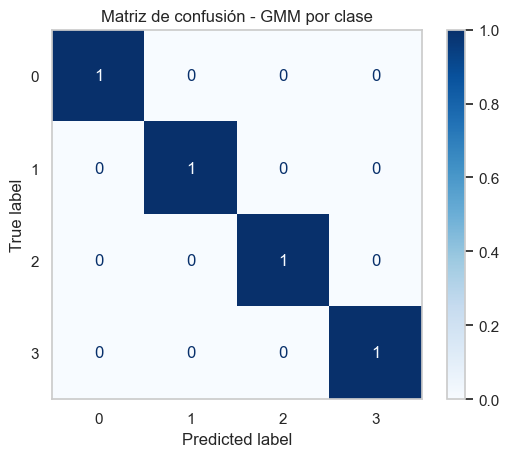

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



In [ ]:
# =====================================================
# 1️⃣  Importar librerías
# =====================================================
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# =====================================================
# 2️⃣  Preparar datos
# =====================================================
# Suponiendo que ya tienes:
#   df_features → features extraídas con cesium
#   df_meta     → contiene columnas ['series_id', 'target']

# --- Imputar NaN y escalar ---
feats_imputed = df_features.fillna(df_features.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(feats_imputed)
X = pd.DataFrame(X_scaled, index=feats_imputed.index, columns=feats_imputed.columns)

# --- Alinear features con etiquetas ---
df_meta_indexed = df_meta.set_index("series_id")
common_ids = X.index.intersection(df_meta_indexed.index)

X = X.loc[common_ids]
y = df_meta_indexed.loc[common_ids, "target"].to_numpy()

print(f"✅ Datos alineados: {len(X)} series, {len(np.unique(y))} clases.")

# =====================================================
# 3️⃣  Entrenar un GMM por clase
# =====================================================
labels = np.unique(y)
gmms = {}

X_np = X.to_numpy()

for label in labels:
    X_class = X_np[y == label]
    gmm = GaussianMixture(
        n_components=3,          # número de gaussianas por clase
        covariance_type='full',  # tipo de covarianza
        reg_covar=1e-4,          # regularización para estabilidad numérica
        random_state=42
    )
    gmm.fit(X_class)
    gmms[label] = gmm

print("✅ Modelos GMM entrenados para clases:", labels)

# =====================================================
# 4️⃣  Función de predicción (clasificación por máxima verosimilitud)
# =====================================================
def predict_gmm(X_input, gmms, labels):
    """Predice la clase más probable según la verosimilitud de cada GMM."""
    log_probs = np.column_stack([
        gmms[label].score_samples(X_input) for label in labels
    ])
    preds = labels[np.argmax(log_probs, axis=1)]
    return preds

# Predicciones en el mismo conjunto (puedes usar split más adelante)
y_pred_gmm = predict_gmm(X_np, gmms, labels)

# =====================================================
# 5️⃣  Evaluación
# =====================================================
acc = accuracy_score(y, y_pred_gmm)
print(f"\n🔹 Accuracy GMM: {acc:.3f}\n")

print("🔹 Reporte de clasificación:")
print(classification_report(y, y_pred_gmm))

# Matriz de confusión
cm = confusion_matrix(y, y_pred_gmm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', colorbar=True)
plt.title("Matriz de confusión - GMM por clase")
plt.grid(False)
plt.show()

# Matriz de confusión
cm = confusion_matrix(y, y_pred_gmm, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', colorbar=True)
plt.title("Matriz de confusión normalizada - GMM por clase")
plt.grid(False)
plt.show()

feats_imputed = df_features.fillna(df_features.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(feats_imputed)
X = pd.DataFrame(X_scaled, index=feats_imputed.index, columns=feats_imputed.columns)

# --- Alinear features con etiquetas ---
df_meta_indexed = df_meta.set_index("series_id")
common_ids = X.index.intersection(df_meta_indexed.index)

X = X.loc[common_ids]
y = df_meta_indexed.loc[common_ids, "target"].to_numpy()
# División estratificada para mantener la proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
labels = np.unique(y)
gmms = {}

for label in labels:
    X_class = X[y == label]
    gmms[label] = GaussianMixture(
        n_components=3,          # o más, según complejidad
        covariance_type='full',
        random_state=42
    )
    gmms[label].fit(X_class)


def predict_gmm(X):
    log_probs = np.column_stack([gmms[label].score_samples(X) for label in labels])
    y_pred = labels[np.argmax(log_probs, axis=1)]
    return y_pred


from sklearn.metrics import classification_report

y_pred = predict_gmm(X_test)
print(classification_report(y_test, y_pred))




## Ramdom Forest

Train: (84, 11), Test: (36, 11)
🔹 Accuracy (Random Forest): 0.917

🔹 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.80      0.89      0.84         9
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         9

    accuracy                           0.92        36
   macro avg       0.92      0.92      0.92        36
weighted avg       0.92      0.92      0.92        36



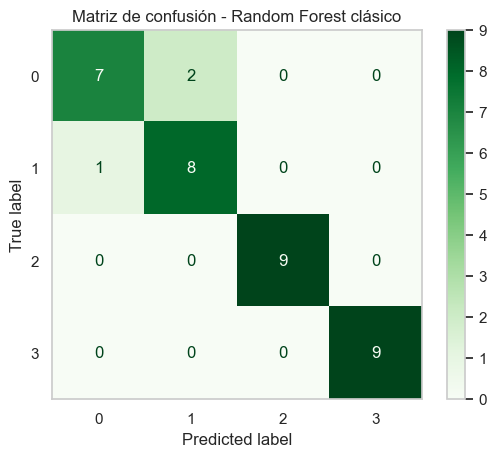

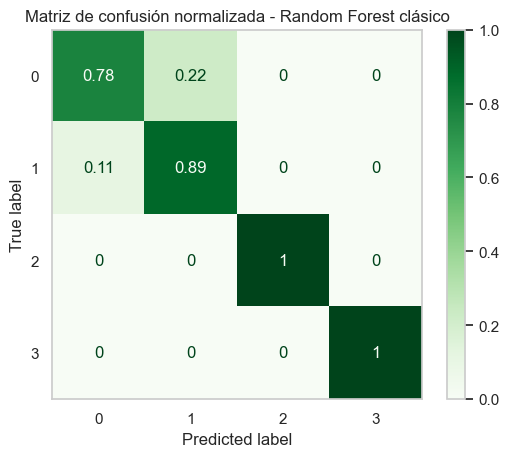

🔹 Accuracy (Balanced RF): 0.861

🔹 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.75      0.67      0.71         9
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         9

    accuracy                           0.86        36
   macro avg       0.86      0.86      0.86        36
weighted avg       0.86      0.86      0.86        36



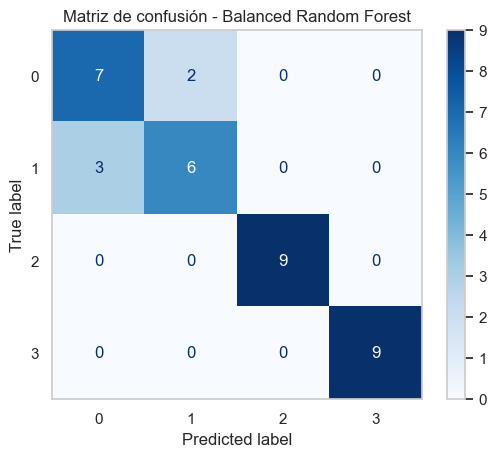

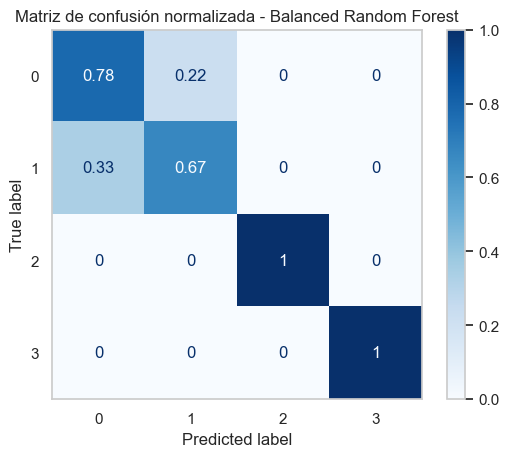

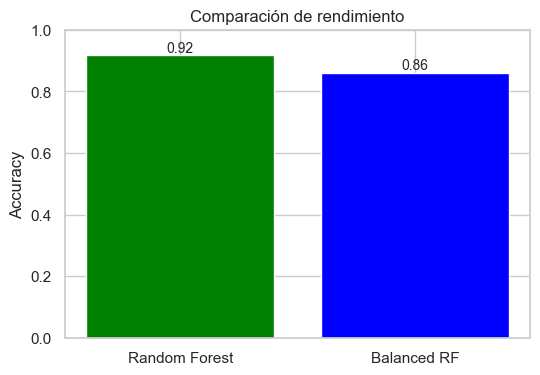

In [30]:
# =====================================================
# 1️⃣ Importar librerías
# =====================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Si no tienes imbalanced-learn:
# !pip install imbalanced-learn
from imblearn.ensemble import BalancedRandomForestClassifier

# =====================================================
# 2️⃣ Dividir datos en entrenamiento y test
# =====================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# =====================================================
# 3️⃣ Entrenar el Random Forest clásico
# =====================================================
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# =====================================================
# 4️⃣ Evaluación del RF clásico
# =====================================================
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"🔹 Accuracy (Random Forest): {acc_rf:.3f}\n")
print("🔹 Reporte de clasificación:")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(cm_rf, display_labels=np.unique(y))
disp_rf.plot(cmap="Greens", colorbar=True)
plt.title("Matriz de confusión - Random Forest clásico")
plt.grid(False)
plt.show()

cm_rf = confusion_matrix(y_test, y_pred_rf, normalize='true')
disp_rf = ConfusionMatrixDisplay(cm_rf, display_labels=np.unique(y))
disp_rf.plot(cmap="Greens", colorbar=True)
plt.title("Matriz de confusión normalizada - Random Forest clásico")
plt.grid(False)
plt.show()


# =====================================================
# 5️⃣ Entrenar el Balanced Random Forest
# =====================================================
brf = BalancedRandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
brf.fit(X_train, y_train)
y_pred_brf = brf.predict(X_test)

# =====================================================
# 6️⃣ Evaluación del Balanced RF
# =====================================================
acc_brf = accuracy_score(y_test, y_pred_brf)
print(f"🔹 Accuracy (Balanced RF): {acc_brf:.3f}\n")
print("🔹 Reporte de clasificación:")
print(classification_report(y_test, y_pred_brf))

cm_brf = confusion_matrix(y_test, y_pred_brf)
disp_brf = ConfusionMatrixDisplay(cm_brf, display_labels=np.unique(y))
disp_brf.plot(cmap="Blues", colorbar=True)
plt.title("Matriz de confusión - Balanced Random Forest")
plt.grid(False)
plt.show()

cm_brf = confusion_matrix(y_test, y_pred_brf, normalize='true')
disp_brf = ConfusionMatrixDisplay(cm_brf, display_labels=np.unique(y))
disp_brf.plot(cmap="Blues", colorbar=True)
plt.title("Matriz de confusión normalizada - Balanced Random Forest")
plt.grid(False)
plt.show()

# =====================================================
# 7️⃣ Comparación gráfica rápida
# =====================================================
plt.figure(figsize=(6,4))
plt.bar(["Random Forest", "Balanced RF"], [acc_rf, acc_brf], color=["green", "blue"])
plt.ylabel("Accuracy")
plt.title("Comparación de rendimiento")
plt.ylim(0, 1)
for i, v in enumerate([acc_rf, acc_brf]):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center", fontsize=10)
plt.show()


# Clasificadores de Redes Neuronales

In [21]:
# =====================================================
# 1️⃣ Importar librerías
# =====================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [22]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.2):

        super().__init__()


        self.mlp_net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 4)
        )

    def forward(self, x):
        return self.mlp_net(x)

In [12]:
class CNNFeatures(nn.Module):
   
    def __init__(self,
                 n_features,
                 n_classes,
                 in_channels=1,
                 channels=(16, 32),
                 kernel_sizes=(3, 3),
                 pool_kernel=2,
                 dropout=0.2):
        super().__init__()
        assert len(channels) == len(kernel_sizes), "channels y kernel_sizes deben tener el mismo largo"
        self.n_features = n_features

        
        self.in_channels = in_channels

        blocks = []
        curr_in = in_channels
        for out_ch, k in zip(channels, kernel_sizes):
          
            padding = k // 2
            blocks += [
                nn.Conv1d(curr_in, out_ch, kernel_size=k, padding=padding),
                nn.BatchNorm1d(out_ch),
                nn.ReLU(inplace=True),
                nn.MaxPool1d(kernel_size=pool_kernel, stride=pool_kernel)
            ]
            curr_in = out_ch

        self.encoder = nn.Sequential(*blocks)

        
        self.global_pool = nn.AdaptiveAvgPool1d(1)  

        # Clasificador final
        self.classifier = nn.Sequential(
            nn.Flatten(),               
            nn.Dropout(dropout),
            nn.Linear(curr_in, n_classes)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        
        if x.dim() == 2:
            
            x = x.unsqueeze(1)
        else:
            
            pass

        
        x = self.encoder(x)          
        x = self.global_pool(x)      
        out = self.classifier(x)     
        return out


In [13]:
class EarlyStopping:
    def __init__(self, n_epochs_tolerance):
        self.n_epochs_tolerance = n_epochs_tolerance
        self.epochs_with_no_improvement = 0
        self.best_loss = np.inf

    def __call__(self, val_loss):
        # En cada llamada aumentamos el número de épocas en que no hemos mejorado
        self.epochs_with_no_improvement += 1

        if val_loss <= self.best_loss:
            # Si efectivamente mejoramos (menor loss de validación) reiniciamos el número de épocas sin mejora
            self.best_loss = val_loss
            self.epochs_with_no_improvement = 0

        # Retornamos True si debemos detenernos y False si aún no
        # Nos detenemos cuando el número de épocas sin mejora es mayor o igual que el número de épocas de tolerancia
        return self.epochs_with_no_improvement >= self.n_epochs_tolerance

In [36]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
import random
def plot_cm(model, dataset, batch_size=128, class_names=None, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    # loader
    if isinstance(dataset, torch.utils.data.DataLoader):
        loader = dataset
    else:
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    model.eval()

    y_trues, y_preds = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            outputs = model(x)                    
            preds = outputs.argmax(dim=1).cpu().numpy()

            
            if y.dim() == 2 and y.size(1) > 1:
                y = y.argmax(dim=1)
            y = y.cpu().numpy()

            y_trues.append(y)
            y_preds.append(preds)

    y_true = np.concatenate(y_trues, axis=0)
    y_pred = np.concatenate(y_preds, axis=0)

    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=(class_names if class_names is not None else None))
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, values_format='d', cmap='viridis')  
    plt.title("Matriz de confusión")
    plt.show()

# Entrenamiento

In [38]:
def show_curves(all_curves):

    final_curve_means = {k: np.mean([c[k] for c in all_curves], axis=0) for k in all_curves[0].keys()}
    final_curve_stds = {k: np.std([c[k] for c in all_curves], axis=0) for k in all_curves[0].keys()}

    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(final_curve_means["val_loss"])) + 1

    ax[0].plot(epochs, final_curve_means['val_loss'], label='validation')
    ax[0].plot(epochs, final_curve_means['train_loss'], label='training')
    ax[0].fill_between(epochs, y1=final_curve_means["val_loss"] - final_curve_stds["val_loss"], y2=final_curve_means["val_loss"] + final_curve_stds["val_loss"], alpha=.5)
    ax[0].fill_between(epochs, y1=final_curve_means["train_loss"] - final_curve_stds["train_loss"], y2=final_curve_means["train_loss"] + final_curve_stds["train_loss"], alpha=.5)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, final_curve_means['val_acc'], label='validation')
    ax[1].plot(epochs, final_curve_means['train_acc'], label='training')
    ax[1].fill_between(epochs, y1=final_curve_means["val_acc"] - final_curve_stds["val_acc"], y2=final_curve_means["val_acc"] + final_curve_stds["val_acc"], alpha=.5)
    ax[1].fill_between(epochs, y1=final_curve_means["train_acc"] - final_curve_stds["train_acc"], y2=final_curve_means["train_acc"] + final_curve_stds["train_acc"], alpha=.5)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

def get_metrics_and_confusion_matrix(model, dataset):
    model.cpu()
    model.eval()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=min(16, len(dataset)))
    y_true = []
    y_pred = []
    for x, y in dataloader:
        y_true.append(y)
        y_pred.append(model(x).argmax(dim=1))

    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)

    print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")
    print(classification_report(y_true, y_pred))

In [39]:
import time

def NN_classifier(model, train_dataset, val_dataset, epochs, criterion, batch_size, lr, early_stopping_tolerance=15, use_GPU=False):

    if use_GPU:
        model.cuda()

    early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance)

    #dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    #optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": []
    }

    # Early stopping
    n_epochs_with_no_improvement = 0
    stop = False

    t0 = time.perf_counter()

    for epoch in range(epochs):
        cumulative_train_loss = 0
        cumulative_train_corrects = 0

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            print(f"\rEpoch {epoch + 1}/{epochs} - Batch {i}/{len(train_loader)}", end="")
            if use_GPU:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            # Predicción
            y_predicted = model(x_batch)

            y_batch = y_batch.long().squeeze()

            # Cálculo de loss
            loss = criterion(y_predicted, y_batch)

            # Actualización de parámetros
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cumulative_train_loss += loss.item()

            preds = y_predicted.argmax(dim=1)
            cumulative_train_corrects += (y_batch == preds).sum()

        train_loss = cumulative_train_loss / len(train_loader)
        train_acc = cumulative_train_corrects / len(train_dataset)

        # Evaluación del modelo
        model.eval()
        x_val, y_val = next(iter(val_loader))

        if use_GPU:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        y_val = y_val.long().squeeze()
        loss = criterion(y_predicted, y_val)

        class_prediction = y_predicted.argmax(dim=1)
        val_acc = (y_val == class_prediction).sum() / y_val.shape[0]
        val_loss = loss.item()

        curves["train_acc"].append(train_acc.item())
        curves["val_acc"].append(val_acc.item())
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        print(f" - Train loss: {train_loss}, Train acc: {train_acc}, Val loss: {val_loss}, Val acc: {val_acc}")

        if early_stopping(val_loss):
            print("Early stopping.")
            break

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    from sklearn.metrics import (
            classification_report,
            accuracy_score,
            precision_score,
            recall_score,
            f1_score,
            precision_recall_fscore_support
        )


    #Imprimir métricas
    try:
        y_true_np = y_val.detach().cpu().numpy().astype(int).ravel()
    except:
        y_true_np = y_val.cpu().numpy().astype(int).ravel()
    try:
        y_pred_np = class_prediction.detach().cpu().numpy().astype(int).ravel()
    except:
        y_pred_np = class_prediction.cpu().numpy().astype(int).ravel()
    # Accuracy
    acc = float(accuracy_score(y_true_np, y_pred_np))
    # Precision/Recall/F1: micro, macro, weighted
    p_macro = float(precision_score(y_true_np, y_pred_np, average="macro", zero_division=0))
    p_micro = float(precision_score(y_true_np, y_pred_np, average="micro", zero_division=0))
    p_weighted = float(precision_score(y_true_np, y_pred_np, average="weighted", zero_division=0))
    r_macro = float(recall_score(y_true_np, y_pred_np, average="macro", zero_division=0))
    r_micro = float(recall_score(y_true_np, y_pred_np, average="micro", zero_division=0))
    r_weighted = float(recall_score(y_true_np, y_pred_np, average="weighted", zero_division=0))
    f1_macro = float(f1_score(y_true_np, y_pred_np, average="macro", zero_division=0))
    f1_micro = float(f1_score(y_true_np, y_pred_np, average="micro", zero_division=0))
    f1_weighted = float(f1_score(y_true_np, y_pred_np, average="weighted", zero_division=0))
    # Per-class metrics (precision, recall, f1, support)

    if y_true_np.size == 0:
        labels = []
    else:
        max_label = int(max(y_true_np.max() if y_true_np.size>0 else 0, y_pred_np.max() if y_pred_np.size>0 else 0))
        labels = list(range(max_label + 1))
    perclass = precision_recall_fscore_support(y_true_np, y_pred_np, labels=labels, zero_division=0)
    per_precisions = perclass[0]
    per_recalls = perclass[1]
    per_f1s = perclass[2]
    per_support = perclass[3]
    # Imprimir resumen compacto
    print("\nValidation metrics summary:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision -> macro: {p_macro:.4f}, micro: {p_micro:.4f}, weighted: {p_weighted:.4f}")
    print(f"  Recall    -> macro: {r_macro:.4f}, micro: {r_micro:.4f}, weighted: {r_weighted:.4f}")
    print(f"  F1-score  -> macro: {f1_macro:.4f}, micro: {f1_micro:.4f}, weighted: {f1_weighted:.4f}")
    # Imprimir tabla por clase
    if len(labels) > 0:
        print("\nPer-class metrics:")
        print("{:>10} {:>10} {:>10} {:>10}".format("Class", "Precision", "Recall", "F1"))
        for idx, lab in enumerate(labels):
            print("{:>10} {:10.4f} {:10.4f} {:10.4f} (support={})".format(
                str(lab), float(per_precisions[idx]), float(per_recalls[idx]), float(per_f1s[idx]), int(per_support[idx])
            ))

    try:
        report = classification_report(y_true_np, y_pred_np, zero_division=0)
        print("\nClassification report (validation):\n", report)
    except Exception as e:
        print("No se pudo generar classification_report:", e)

    model.cpu()

    return curves


In [34]:
import time
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)

        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item() * y_val.shape[0]
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / data_count

    return val_acc, val_loss


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    early_stopping_tolerance=15,
    n_evaluations_per_epoch=6,
    use_gpu=False,
):
    if use_gpu:
        model.cuda()


    early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance)
    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }


        # Early stopping
    n_epochs_with_no_improvement = 0
    stop = False

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)
    print(n_batches)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        examples_count = 0

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item() * x_batch.shape[0]
            examples_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / examples_count
                train_acc = cumulative_train_corrects / examples_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1

        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / examples_count
        train_acc = cumulative_train_corrects / examples_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)
        if early_stopping(val_loss):
            print("Early stopping.")
            break
    print()
    total_time = time.perf_counter() - t0
    print(f"Tiempo total de entrenamiento: {total_time:.4f} [s]")

    model.cpu()

    return curves, total_time

In [18]:
# Si tus datos vienen de scikit-learn, conviértelos a tensores
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

# Crear datasets y loaders
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [35]:
lr = 5e-4
batch_size = 4
criterion = nn.CrossEntropyLoss()
n_trains = 5

epochs = 40

all_curves = []
times = []

for train_run in range(n_trains):
    model = MLPModel(input_size=X_train_t.shape[1], hidden_size=20, dropout_rate=0.5)  # INSERTE CÓDIGO

    curves, total_time = train_model(
        model,
        train_dataset,
        test_dataset,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)



21
Epoch 1/40
Iteration 3 - Batch 3/21 - Train loss: 1.5563485026359558, Train acc: 0.0
Iteration 6 - Batch 6/21 - Train loss: 1.4487097774233137, Train acc: 0.21428571428571427
Iteration 9 - Batch 9/21 - Train loss: 1.451477825641632, Train acc: 0.2
Iteration 12 - Batch 12/21 - Train loss: 1.4474239716163049, Train acc: 0.21153846153846154
Iteration 15 - Batch 15/21 - Train loss: 1.4306457042694092, Train acc: 0.234375
Iteration 18 - Batch 18/21 - Train loss: 1.4257589453145076, Train acc: 0.2236842105263158
Val loss: 1.3941788540946112, Val acc: 0.3055555555555556
Epoch 2/40
Iteration 24 - Batch 3/21 - Train loss: 1.410716474056244, Train acc: 0.25
Iteration 27 - Batch 6/21 - Train loss: 1.3696029015949793, Train acc: 0.32142857142857145
Iteration 30 - Batch 9/21 - Train loss: 1.3819787740707397, Train acc: 0.275
Iteration 33 - Batch 12/21 - Train loss: 1.4144407143959632, Train acc: 0.21153846153846154
Iteration 36 - Batch 15/21 - Train loss: 1.4104751572012901, Train acc: 0.234375


KeyboardInterrupt: 

In [ ]:
def plot_cm(model, dataset, batch_size=128, class_names=None, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    # loader
    if isinstance(dataset, torch.utils.data.DataLoader):
        loader = dataset
    else:
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    model.eval()

    y_trues, y_preds = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            outputs = model(x)                    
            preds = outputs.argmax(dim=1).cpu().numpy()

            
            if y.dim() == 2 and y.size(1) > 1:
                y = y.argmax(dim=1)
            y = y.cpu().numpy()

            y_trues.append(y)
            y_preds.append(preds)

    y_true = np.concatenate(y_trues, axis=0)
    y_pred = np.concatenate(y_preds, axis=0)

    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=(class_names if class_names is not None else None))
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, values_format='d', cmap='viridis')  
    plt.title("Matriz de confusión")
    plt.show()#Matriz de confusión

    
cm = plot_cm(model, test_dataset, batch_size=4, class_names=['0','1','2','3'], device='cuda' if use_gpu else 'cpu')

NameError: name 'use_gpu' is not defined

21
Epoch 1/40
Iteration 3 - Batch 3/21 - Train loss: 2.360622525215149, Train acc: 0.3125
Iteration 6 - Batch 6/21 - Train loss: 2.430952651160104, Train acc: 0.21428571428571427
Iteration 9 - Batch 9/21 - Train loss: 2.4039904356002806, Train acc: 0.225
Iteration 12 - Batch 12/21 - Train loss: 2.4014710004513082, Train acc: 0.23076923076923078
Iteration 15 - Batch 15/21 - Train loss: 2.37748271971941, Train acc: 0.203125
Iteration 18 - Batch 18/21 - Train loss: 2.3433316130387154, Train acc: 0.2236842105263158
Val loss: 1.8227686219745212, Val acc: 0.3333333333333333
Epoch 2/40
Iteration 24 - Batch 3/21 - Train loss: 1.4015101790428162, Train acc: 0.5
Iteration 27 - Batch 6/21 - Train loss: 1.768604074205671, Train acc: 0.39285714285714285
Iteration 30 - Batch 9/21 - Train loss: 1.9528276681900025, Train acc: 0.35
Iteration 33 - Batch 12/21 - Train loss: 1.9848668575286865, Train acc: 0.3269230769230769
Iteration 36 - Batch 15/21 - Train loss: 1.937514379620552, Train acc: 0.34375
Ite

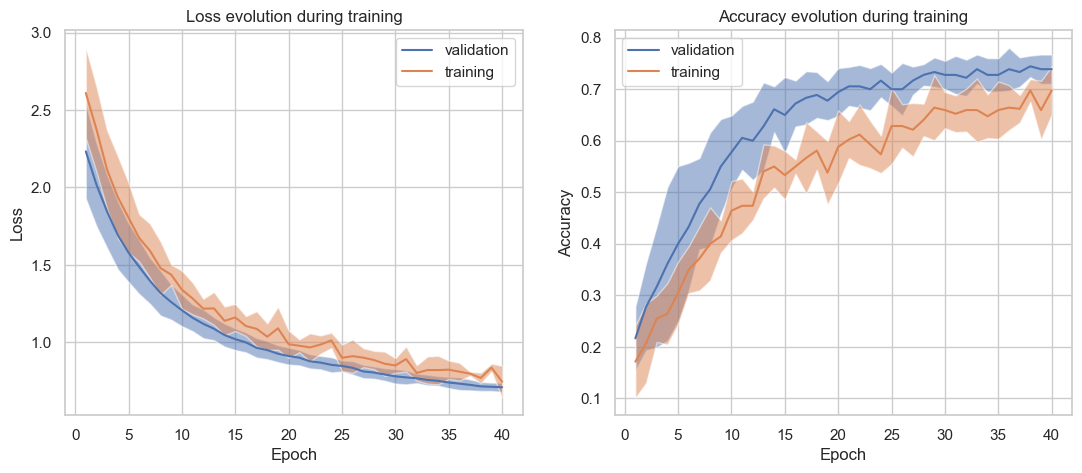

NameError: name 'use_gpu' is not defined

In [ ]:
lr = 5e-4
batch_size = 4
criterion = nn.CrossEntropyLoss()
n_trains = 5
n_features = 11
n_classes = 8

epochs = 40

all_curves = []
times = []

for train_run in range(n_trains):
    model = CNNFeatures(n_features=n_features,
                        n_classes=n_classes,
                        in_channels=1,
                        channels=(16, 32),
                        kernel_sizes=(5, 3),
                        pool_kernel=2,
                        dropout=0.3)

    curves, total_time = train_model(
        model,
        train_dataset,
        test_dataset,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)


In [40]:
#Matriz de confusión
cm = plot_cm(model, test_dataset, batch_size=4, class_names=['0','1','2','3'], device='cuda' if use_gpu else 'cpu')

NameError: name 'use_gpu' is not defined